# 把Google Driver挂载到硬盘 (Mount Google Driver)

In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive


In [3]:
print('Files in Drive:')
!ls drive/MachineLearning/images

Files in Drive:
camp-nou.jpg		NST_LOSS.png		 tantan+fangao.png
cat.jpg			persian_cat_content.jpg  tantan.jpg
claude-monet.jpg	persian_cat.jpg		 the-starry-night-1888-2.jpg
fangao.jpg		perspolis_vangogh.png	 ustb-1.jpg
impression-sunrise.jpg	reshape_loss.png	 ustb+starry_night_2.png
louvre.jpg		result.png		 ustb+starry_night-3.png
louvre_small.jpg	sandstone.jpg		 ustb+starry_night.png
monet_800600.jpg	starry_night.jpg	 ustb+sunrise.png
monet.jpg		stone_style.jpg
NST_GM.png		style300.jpg


# 神经风格迁移 (Neural Style Transfer)

主要使用keras，后端默认为tensorflow

In [4]:
!pip install -U scipy==1.2.0

     |████████████████████████████████| 26.6MB 104kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.2.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [5]:
import os
import sys
from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg16, vgg19
from keras import backend as K

import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


In [6]:
def generate_noise_image(base_image, noise_ratio = 0.6):
    noise_image = np.random.uniform(-20, 20, (1, img_nrows, img_ncols, 3)).astype('float32')
    input_image = noise_image * noise_ratio + base_image * (1 - noise_ratio)
    return input_image

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    assert K.image_data_format() == 'channels_last'
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR' -> 'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

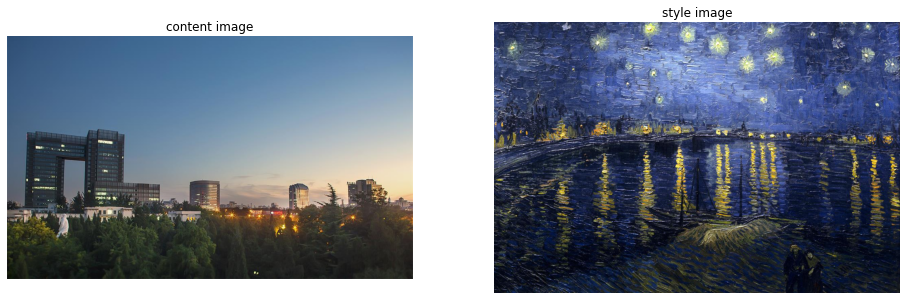

In [20]:
content_weight = 1
style_weight = 100

iterations = 10

base_image_path = "./drive/MachineLearning/images/ustb-1.jpg"
style_image_path = "./drive/MachineLearning/images/the-starry-night-1888-2.jpg"
# imshow(load_img(base_image_path))

plt.figure(num='astronaut',figsize=(16,8))  #创建一个名为astronaut的窗口,并设置大小 

plt.subplot(1,2,1)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('content image')   #标题
plt.imshow(load_img(base_image_path))
plt.axis('off')

plt.subplot(1,2,2)   
plt.title('style image')  
plt.imshow(load_img(style_image_path))
# plt.imshow(load_img(base_image_path))
plt.axis('off')

width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [28]:
base_image = K.variable(preprocess_image(base_image_path))
style_image = K.variable(preprocess_image(style_image_path))

assert K.image_data_format() == 'channels_last'
generated_image = K.placeholder((1, img_nrows, img_ncols, 3))

input_tensor = K.concatenate([base_image,
                             style_image,
                             generated_image], axis=0)

In [29]:
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded')
model.summary()

Model loaded
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 

In [30]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict)

{'input_3': <tf.Tensor 'concat_2:0' shape=(3, 400, 666, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 400, 666, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 400, 666, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 200, 333, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 200, 333, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 200, 333, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 100, 166, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 100, 166, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 100, 166, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 100, 166, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4_2/Relu:0' shape=(3, 100, 166, 256) dtype=float32>, 'block

# 计算损失函数 (Caluate Loss Function)

In [31]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    assert K.image_data_format() == 'channels_last'
    A = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    GA = K.dot(A, K.transpose(A))
    return GA

def style_loss(a_S, a_G):
    assert K.ndim(a_S) == 3
    assert K.ndim(a_G) == 3    
    S = gram_matrix(a_S)
    G = gram_matrix(a_G)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

# def style_loss(a_S, a_G):
    

def content_loss(a_C, a_G):
    assert K.ndim(a_C) == 3
    assert K.ndim(a_G) == 3
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(a_C - a_G)) / (4. * channels * size)

In [32]:
loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2']
base_features = layer_features[0, :, :, :]
generated_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_features, generated_features)

feature_layers = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]
loss_style = 0
for layer_name, coeff in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss_style += coeff * style_loss(style_features, generated_features)
loss += style_weight * loss_style

grads = K.gradients(loss, generated_image)

outputs = [loss]
assert type(grads) == type([])
outputs += grads

In [33]:
f_outputs = K.function([generated_image], outputs)

In [34]:
def eval_loss_and_grads(x):
    assert K.image_data_format() == 'channels_last'
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    assert len(outs[1:]) == 1
#     print(len(outs[1:]))
    grads_values = outs[1].flatten().astype('float64')
    return loss_value, grads_values

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None        
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grads_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_values = grads_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_values)
        self.loss_value = None
        self.grads_values = None
        return grads_values
    
evaluator = Evaluator()

(-0.5, 665.5, 399.5, -0.5)

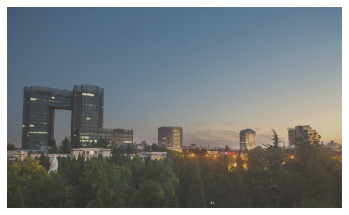

In [35]:
x = generate_noise_image(preprocess_image(base_image_path), noise_ratio=0.3)
# x = preprocess_image(base_image_path)
plt.imshow(deprocess_image(x))
plt.axis('off')

In [36]:
x = generate_noise_image(preprocess_image(base_image_path), noise_ratio=0.3)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value: ', min_val)
    # save the generated image
    img = deprocess_image(x.copy())
    fname = 'generated_image' + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds\n' % (i, end_time - start_time))

Start of iteration 0
Current loss value:  113748850000.0
Image saved as generated_image_at_iteration_0.png
Iteration 0 completed in 19s

Start of iteration 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':


Current loss value:  34693640000.0
Image saved as generated_image_at_iteration_1.png
Iteration 1 completed in 20s

Start of iteration 2
Current loss value:  19786627000.0
Image saved as generated_image_at_iteration_2.png
Iteration 2 completed in 19s

Start of iteration 3
Current loss value:  14524402000.0
Image saved as generated_image_at_iteration_3.png
Iteration 3 completed in 19s

Start of iteration 4
Current loss value:  11825689000.0
Image saved as generated_image_at_iteration_4.png
Iteration 4 completed in 19s

Start of iteration 5
Current loss value:  9159833000.0
Image saved as generated_image_at_iteration_5.png
Iteration 5 completed in 19s

Start of iteration 6
Current loss value:  7781484500.0
Image saved as generated_image_at_iteration_6.png
Iteration 6 completed in 19s

Start of iteration 7
Current loss value:  6988524500.0
Image saved as generated_image_at_iteration_7.png
Iteration 7 completed in 19s

Start of iteration 8
Current loss value:  6389829000.0
Image saved as ge

In [ ]:
plt.imshow(load_img('generated_image_at_iteration_9.png'))
plt.axis('off')

(-0.5, 665.5, 399.5, -0.5)

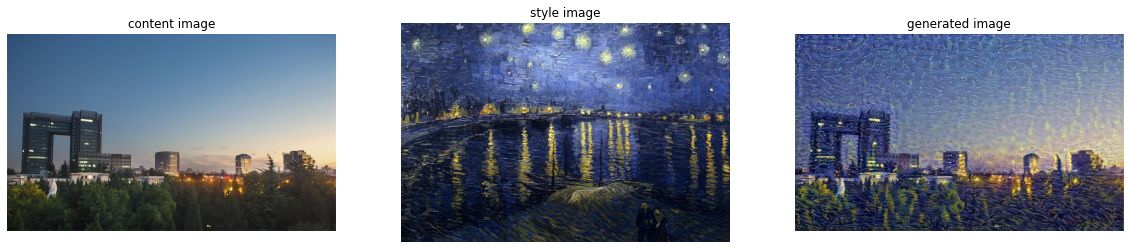

In [37]:
plt.figure(num='astronaut',figsize=(20,10))  #创建一个名为astronaut的窗口,并设置大小 

plt.subplot(1,3,1)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('content image')   #标题
plt.imshow(load_img(base_image_path))
plt.axis('off')

plt.subplot(1,3,2)   
plt.title('style image')  
plt.imshow(load_img(style_image_path))
plt.axis('off')

plt.subplot(1,3,3)   
plt.title('generated image')  
plt.imshow(load_img('generated_image_at_iteration_9.png'))
plt.axis('off')

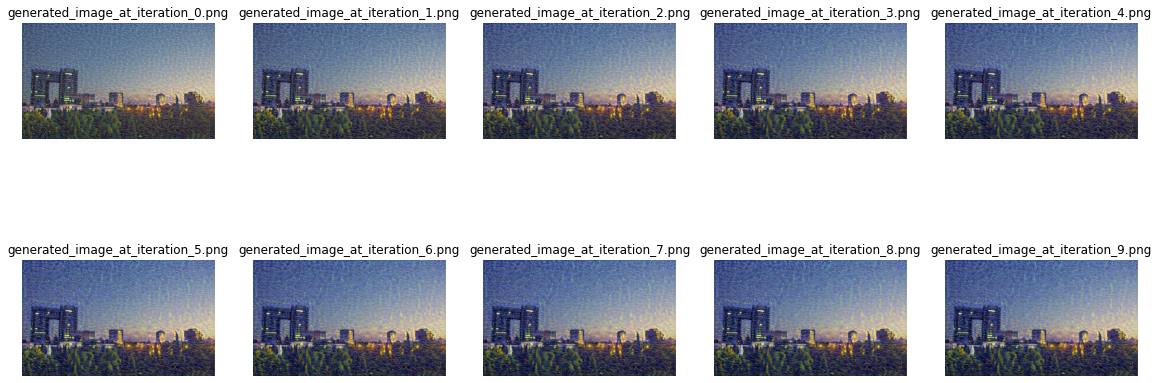

In [38]:
plt.figure(num='tranfer result',figsize=(20,8))

for i in range(iterations):
  plt.subplot(2,5,i+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
  fname = 'generated_image' + '_at_iteration_%d.png' % i
  plt.title(fname)   #第一幅图片标题
  plt.imshow(load_img(fname))
  plt.axis('off')

In [39]:
!cp generated_image_at_iteration_9.png ./drive/MachineLearning/images/ustb+star_3.png